# Introduction to Simpy

In [1]:
!pip install simpy

## First Steps

### The simplest Simpy model

Simpy implements an Environment() object that does the heavy work of scheduling processing events that occur when simulating complex models. The simplest possible Simpy model is one that creates and runs an empty simulation environment.

In [2]:
import simpy

env = simpy.Environment()
env.run()

### Adding a process

The components that make up a Simpy models are implemented using python gnerators. A generator begins with the `def` statement and must have at least one `yield` statement. The yield statement returns an event to the simulation environment. A frequently used events is `simpy.Environment.timeout()` which simulates the passage of time in a model component.

Once the generator has been defined, an instance of the generator is passed to the simulation environment using the `simpy.Environment.process()` method.

The following model defines a process model in which "Hello, World" is printed after a simulated 2.0 seconds have elapsed.

In [3]:
import simpy

def say_hello():
    yield env.timeout(2.0)           # let 2.0 seconds of simulated time elapse
    print("Hello, World")            # print "Hello, World"

env = simpy.Environment()            # create a simulation environment instance
env.process(say_hello())                # register an instance of the process model
env.run()                            # run the simulaton

Hello, World


### Accessing time

The environment variable `simpy.Environment.now` returns the current time in the simulation.

In [4]:
import simpy

def say_hello():
    print("time =", env.now)             # print current time in the simulation
    yield env.timeout(2.0)               # take a time out of 1 time unit
    print("time =", env.now)             # print current time in the simulation
    print("Hello, World")

env = simpy.Environment()                # create a simulation environment instance
env.process(say_hello())                 # tell the simulation environment which generators to process
env.run()                                # run the simulation

time = 0
time = 2.0
Hello, World


### Creating multiple instances of a generator

The same generator can be used to create multiple instances of a model component. For example, this cell creates three instances of a generator. The generator is modified to add an identifier and variable time delay.

**Carefully examine the output of this cell. Be sure you explain the order in which the print statements appear in the output.**

In [5]:
import simpy

def say_hello(id, delay):
    print(id, "time =", env.now)         # print current time in the simulation
    yield env.timeout(delay)             # take a time out of 1 time unit
    print(id, "says Hello, World at time", env.now)

env = simpy.Environment()                # create a simulation environment instance
env.process(say_hello("A", 3.0))         # tell the simulation environment which generators to process
env.process(say_hello("B", 2.0))         # tell the simulation environment which generators to process
env.process(say_hello("C", 4.0))         # tell the simulation environment which generators to process
env.run()                                # run the simulation

A time = 0
B time = 0
C time = 0
B says Hello, World at time 2.0
A says Hello, World at time 3.0
C says Hello, World at time 4.0


### Running a simulation for a known period of time

The simulations presented above finish when all of the components making up the model have finished. In process modeling, however, some model components will simply cycle forever leading to a simulation that would never end. To handle this situation, the `simpy.Environment.run()` has an optional parameter `until` the causes the simulation to end a known point in time.

The next modifies the generator to include an infinite loop, and controls the simulation period using the `until` parameter.

In [6]:
import simpy

def say_hello(id, delay):
    print(id, "time =", env.now)          # print current time in the simulation
    while True:
        yield env.timeout(delay)          # take a time out of 1 time unit
        print(id, "says Hello, World at time", env.now)

env = simpy.Environment()                 # create a simulation environment instance
env.process(say_hello("A", 3.0))          # tell the simulation environment which generators to process
env.process(say_hello("B", 2.0))          # tell the simulation environment which generators to process
env.process(say_hello("C", 4.0))          # tell the simulation environment which generators to process
env.run(until=10.0)                       # run the simulation

A time = 0
B time = 0
C time = 0
B says Hello, World at time 2.0
A says Hello, World at time 3.0
C says Hello, World at time 4.0
B says Hello, World at time 4.0
A says Hello, World at time 6.0
B says Hello, World at time 6.0
C says Hello, World at time 8.0
B says Hello, World at time 8.0
A says Hello, World at time 9.0


### Logging data

Discrete-event simulations can create large amounts of data. A good practice is create a data log for the purpose of capturing data generated during the simulation. After the simulation is complete, the data log can be processed to create reports and charts to analyze results of the simulation.

If not sure what to log, a good practice is log at least three items for each event:

* **who** what object created this event
* **what** a description of the event
* **when** when the event occurred

In [7]:
import simpy

data_log = []                             # create an empty data log

def say_hello(id, delay):
    while True:
        yield env.timeout(delay)          # take a time out of 1 time unit
        data_log.append([id, "Hello, World", env.now])   # log who (id), what ("Hello, World"), when (env.now)

env = simpy.Environment()                 # create a simulation environment instance
env.process(say_hello("A", 3.0))          # tell the simulation environment which generators to process
env.process(say_hello("B", 2.0))          # tell the simulation environment which generators to process
env.process(say_hello("C", 4.0))          # tell the simulation environment which generators to process
env.run(until=10.0)                       # run the simulation

for data_record in data_log:
    print(data_record)

['B', 'Hello, World', 2.0]
['A', 'Hello, World', 3.0]
['C', 'Hello, World', 4.0]
['B', 'Hello, World', 4.0]
['A', 'Hello, World', 6.0]
['B', 'Hello, World', 6.0]
['C', 'Hello, World', 8.0]
['B', 'Hello, World', 8.0]
['A', 'Hello, World', 9.0]


## Example: Simulating a Stirred Tank Reactor

### Model development

Write a Python generator to simulate the response of a differential equation describing concentration in a stirred tank reactor.

$$\frac{dC}{dt} = -k C + q(t)$$

where k = 1.0,  C(0) = 1.0 and q(t) has a constant value 0.5. Use can use the Euler approximation

$$C(t + \Delta t) = C(t) + \Delta t \left[ - k C(t) + q(t) \right]$$

The definition of the generator should allow specification of the time step, $\Delta t$, and the rate constant $k$.

In [11]:
# Solution

import simpy

def flow():
    global q
    q = 0.5
    yield env.timeout(100.0)

def reactor(dt, k):
    C = 1.0
    while True:
        print(round(env.now, 2), round(C, 2))
        yield env.timeout(dt)
        C = C - k*dt*C + q*dt
        
env = simpy.Environment()
env.process(flow())
env.process(reactor(0.5, 1.0))
env.run(until=20)

0 1.0
0.5 0.75
1.0 0.62
1.5 0.56
2.0 0.53
2.5 0.52
3.0 0.51
3.5 0.5
4.0 0.5
4.5 0.5
5.0 0.5
5.5 0.5
6.0 0.5
6.5 0.5
7.0 0.5
7.5 0.5
8.0 0.5
8.5 0.5
9.0 0.5
9.5 0.5
10.0 0.5
10.5 0.5
11.0 0.5
11.5 0.5
12.0 0.5
12.5 0.5
13.0 0.5
13.5 0.5
14.0 0.5
14.5 0.5
15.0 0.5
15.5 0.5
16.0 0.5
16.5 0.5
17.0 0.5
17.5 0.5
18.0 0.5
18.5 0.5
19.0 0.5
19.5 0.5


### Exercise

Extend stirred tank model by adding the following features:

* Modify the flow simulation so that the flowrate initially starts at 0.0, switches to a value of 0.5 at t=1.0, then back to 0.0 five time units later.
* Add a data log to records time and the values of concentration, $C$, and flowrate $q$. After debugging, remove the print statements.
* When the simulation is complete, convert the data log to a numpy array, then create plots of $C(t)$ and $q(t)$. Take time to label axes and, if necessary, add a legend. 
* The whole thing should run in a single cell

In [10]:
# Your solution goes in this cell

## Next steps with Simpy

### Working many simulation objects

Sometimes we wish to do simulations involving many instances of an object type. For these situations it useful to use use Python lists and loops to create multiple instances of a generator and register them with the simulation environment.

In [45]:
import simpy
import random

N = 5

data_log = []                         # create an empty data log

def person(id, delay):
    while True:
        yield env.timeout(delay)      # take a time out of 1 time unit
        data_log.append([id, "Hello, World", env.now])   # log who (id), what ("Hello, World"), when (env.now)

env = simpy.Environment()             # create a simulation environment instance

population = []
for k in range(0, N):
    env.process(person(k, random.uniform(0, 5.0)))
    
env.run(until=10.0)                   # run the simulation

for data_record in data_log:
    print(data_record)

[3, 'Hello, World', 1.083180998934525]
[1, 'Hello, World', 1.8277667545187293]
[0, 'Hello, World', 2.034831190159925]
[3, 'Hello, World', 2.16636199786905]
[4, 'Hello, World', 2.2018086943526076]
[3, 'Hello, World', 3.2495429968035747]
[1, 'Hello, World', 3.6555335090374586]
[0, 'Hello, World', 4.06966238031985]
[2, 'Hello, World', 4.08691031878395]
[3, 'Hello, World', 4.3327239957381]
[4, 'Hello, World', 4.403617388705215]
[3, 'Hello, World', 5.4159049946726245]
[1, 'Hello, World', 5.483300263556188]
[0, 'Hello, World', 6.104493570479775]
[3, 'Hello, World', 6.4990859936071494]
[4, 'Hello, World', 6.605426083057823]
[1, 'Hello, World', 7.311067018074917]
[3, 'Hello, World', 7.582266992541674]
[0, 'Hello, World', 8.1393247606397]
[2, 'Hello, World', 8.1738206375679]
[3, 'Hello, World', 8.6654479914762]
[4, 'Hello, World', 8.80723477741043]
[1, 'Hello, World', 9.138833772593646]
[3, 'Hello, World', 9.748628990410724]


In [49]:
import simpy
import random
import pandas as pd

N = 5

data_log = []                         # create an empty data log

def person(id, delay):
    while True:
        yield env.timeout(delay)      # take a time out of 1 time unit
        data_log.append([id, "Hello, World", env.now])   # log who (id), what ("Hello, World"), when (env.now)

env = simpy.Environment()             # create a simulation environment instance

population = []
for k in range(0, N):
    env.process(person(k, random.uniform(0, 5.0)))
    
env.run(until=10.0)                   # run the simulation

df = pd.DataFrame(data_log, columns=["id", "event", "time"])           # convert the data log to a Pandas dataframe
df.head(10)                                                            # print the first five lines

,id,event,time
0,0,"Hello, World",0.462251
1,0,"Hello, World",0.924501
2,3,"Hello, World",1.244519
3,0,"Hello, World",1.386752
4,0,"Hello, World",1.849003
5,0,"Hello, World",2.311253
6,3,"Hello, World",2.489038
7,2,"Hello, World",2.512738
8,0,"Hello, World",2.773504
9,0,"Hello, World",3.235755


The following cells demonstrates a very simple visualization of the data from the Pandas data frame.

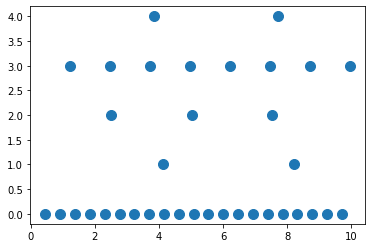

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(df["time"], df["id"], '.', ms=20)

Pandas make it convenient to sort and select events out of the data log. As an example, the next selects all events corresponding for the object id "3".

In [54]:
df[df["id"] == 3]

,id,event,time
2,3,"Hello, World",1.244519
6,3,"Hello, World",2.489038
11,3,"Hello, World",3.733556
16,3,"Hello, World",4.978075
21,3,"Hello, World",6.222594
25,3,"Hello, World",7.467113
31,3,"Hello, World",8.711632
35,3,"Hello, World",9.956150


### Visualizing data logs with Pandas

One of the challenges of discrete-event simulations, especially those involving many simulation objects interacting in complex ways, is to create reports and charts that summarize the resuts. Fortunately, Python is very well suited to managing large data sets. One of the most useful Python tools for data analysis is widely available [Pandas](https://pandas.pydata.org/docs/) library. There excellent [tutorials](https://www.datacamp.com/community/tutorials/pandas-tutorial-dataframe-python) to help you get started with Pandas.

## Monitoring

The purpose of simulation is to gather information on systems behave. For that  purpose, we need to monitor. An easy way to do this is to append data to a log.

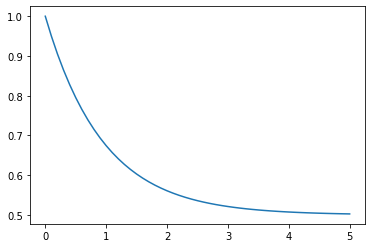

In [30]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

q = 0.5

data_log = []

def reactor(dt, k):
    C = 1.0
    while True:
        data_log.append([env.now, C])
        yield env.timeout(dt)
        C = C - k*dt*C + q*dt
        
env = simpy.Environment()
env.process(reactor(0.1, 1.0))
env.run(until=5)

data =  np.array(data_log)
plt.plot(data[:,0], data[:,1])

## Creating Events

Start Reactor


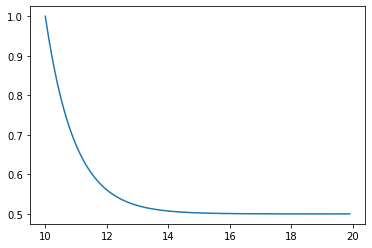

In [35]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

q = 0.5

data_log = []

def startup():
    yield env.timeout(10)
    print("Start Reactor")
    start_reactor.succeed()

def reactor(dt, k):
    yield start_reactor
    C = 1.0
    while True:
        data_log.append([env.now, C])
        yield env.timeout(dt)
        C = C - k*dt*C + q*dt
        
env = simpy.Environment()
start_reactor = env.event()
env.process(startup())
env.process(reactor(0.1, 1.0))
env.run(until=20)

data =  np.array(data_log)
plt.plot(data[:,0], data[:,1])

## Modeling COVID


$$\text{Susceptible}
\xrightarrow {\frac{\beta S I}{N}} 
\text{Exposed} 
\xrightarrow{\alpha E} 
\text{Infectious} 
\xrightarrow{\gamma I} 
\text{Recovered} $$


In [38]:
import simpy

N = 20

def infect():
    k = 0
    while k < N:
        yield env.timeout(1)
        infect_person[k].succeed()
        k = k + 1
        
def person(id):
    yield infect_person[id]
    print(id, "infected at time", env.now)
    
env = simpy.Environment()

population = [person(k) for k in range(N)]
infect_person = [env.event() for k in range(N)]

env.process(infect())
for k in range(20):
    env.process(person(k))
env.run()


0 infected at time 1
1 infected at time 2
2 infected at time 3
3 infected at time 4
4 infected at time 5
5 infected at time 6
6 infected at time 7
7 infected at time 8
8 infected at time 9
9 infected at time 10
10 infected at time 11
11 infected at time 12
12 infected at time 13
13 infected at time 14
14 infected at time 15
15 infected at time 16
16 infected at time 17
17 infected at time 18
18 infected at time 19
19 infected at time 20
